# Linearity and energy resolution

I want to compute the linearity and energy resolution since I may need it for some clustering metrics.

In [133]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import os
import yaml
import math as ma
from scipy.stats import crystalball
import scipy.optimize as opt
import pickle


os.chdir('/home/bjartur/workspace/python_focalh_clustering/') # Laptop and Desktop

In [12]:
def rices_rule(arr):
    """
    Rule for choosing bin size. Cube root times 2.
    https://www.statisticshowto.com/choose-bin-sizes-statistics/#choose
    """
    return np.round((len(arr))**(1/3)*2, 0).astype(int)


# Should use crystal ball instead
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))


def lin(x,m,b):
    return m*x + b


def crystal_ball(x, alpha, n, mu, sigma, norm=True, scipy=False):
    """
    Implementation of the Crystal Ball function from: https://en.wikipedia.org/wiki/Crystal_Ball_function
     
    Backup: from scipy.stats import crystalball
    -> crystalball.pdf(x, beta=10, m=1.1, loc=0, scale=1)
    """

    if scipy:
        return crystalball.pdf(x, beta=alpha, m=n, loc=mu, scale=sigma)
    
    ret = np.zeros_like(x)

    A = (n/np.abs(alpha))**n * np.exp(-(np.abs(alpha)**2)/2)
    B = n/np.abs(alpha) - np.abs(alpha)

    if norm:
        C = (n/np.abs(alpha)) * (1/(n-1)) * np.exp(-(np.abs(alpha)**2)/2)
        D = np.sqrt(np.pi/2) * (1 + ma.erf(np.abs(alpha)/np.sqrt(2)))
        N = 1/(sigma*(C+D))
    else:
        N=1
    
    diff = x-mu
    mask = diff/sigma > -alpha

    # Case 1
    ret[mask] = N*np.exp(-0.5*(diff[mask]**2))

    # Case 2
    ret[~mask] = N * A * (B - diff[~mask])**(-n)
    
    return ret

def plot_crystal_ball(alpha, n, mu, sigma, ax, label):
    x = np.linspace(-10,10,1000)
    y = crystal_ball(x, alpha, n, mu, sigma)
    ax.plot(x,y,label=label)


In [3]:
def load_yaml(data):
    fname = "/home/bjartur/workspace/python_focalh_clustering/analysis/data.yaml"
    with open(fname, "r") as file:
        config = yaml.safe_load(file)
    return config[data]




en350 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/350_1000_uniform_noped_generic.root"
en350 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/TRAIN_E350_N5600_GEN.root"

en300 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/300_1000_uniform_noped_generic.root"
en250 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/250_1000_uniform_noped_generic.root"
en200 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/200_1000_uniform_generic.root"
en150 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/150_1000_uniform_noped_generic.root"
en100 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/100_1000_uniform_noped_generic.root"
en80 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/80_1000_uniform_noped_generic.root"
en60 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/60_1000_uniform_noped_generic.root"
en40 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/40_1000_uniform_noped_generic.root"
en20 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/20_1000_uniform_noped_generic.root"

"""
en300 = "data/train/TRAIN_E300_P1_N100.root"
en250 = "data/train/TRAIN_E250_P1_N100.root"
en200 = "data/train/TRAIN_E200_P1_N100.root"
en150 = "data/train/TRAIN_E150_P1_N100.root"
en100 = "data/train/TRAIN_E100_P1_N100.root"
en80 = "data/train/TRAIN_E80_P1_N100.root"
en60 = "data/train/TRAIN_E60_P1_N100.root"
en40 = "data/train/TRAIN_E40_P1_N100.root"
en20 = "data/train/TRAIN_E20_P1_N100.root"
"""

def adc(fname):
    tfile = ROOT.TFile(fname, "READ")
    ttree = tfile.Get("EventsTree")
    Nentries = ttree.GetEntries()
    adc = np.zeros(Nentries)
    for e in range(Nentries):
        ttree.GetEntry(e)
        vals = np.array(ttree.value, dtype=np.float32)
        adc[e] = vals.sum()
    return adc




In [4]:
adc350 = adc(en350)
adc150 = adc(en150)


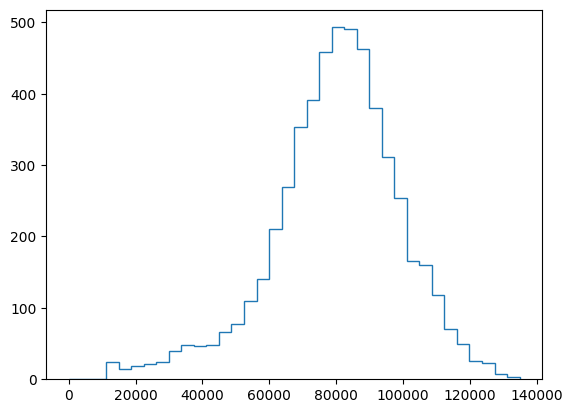

In [28]:
Nbins = rices_rule(adc350)
#Nbins = 30
hist, bins = np.histogram(adc350, bins=Nbins)
bin_centers = bins[:-1] + np.diff(bins) / 2
mask = bin_centers < 12E3
hist[mask] = 0
plt.stairs(hist, bins)


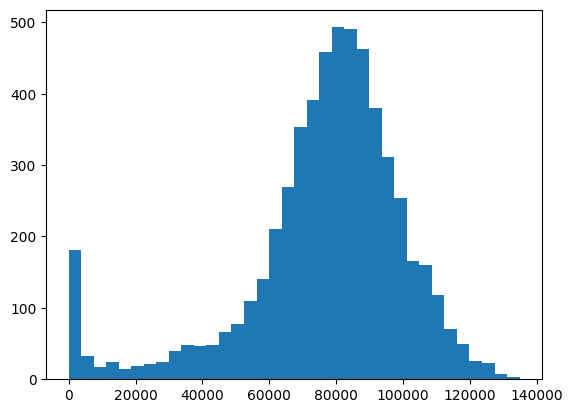

In [15]:
_ = plt.hist(adc350, bins=rices_rule(adc350))

(array([ 33.,   8.,   1.,   8.,  12.,   6.,  12.,  19.,  23.,  32.,  61.,
        102., 157., 169., 152.,  94.,  69.,  30.,  11.,   1.]),
 array([    0. ,  3354.4,  6708.8, 10063.2, 13417.6, 16772. , 20126.4,
        23480.8, 26835.2, 30189.6, 33544. , 36898.4, 40252.8, 43607.2,
        46961.6, 50316. , 53670.4, 57024.8, 60379.2, 63733.6, 67088. ]),
 <BarContainer object of 20 artists>)

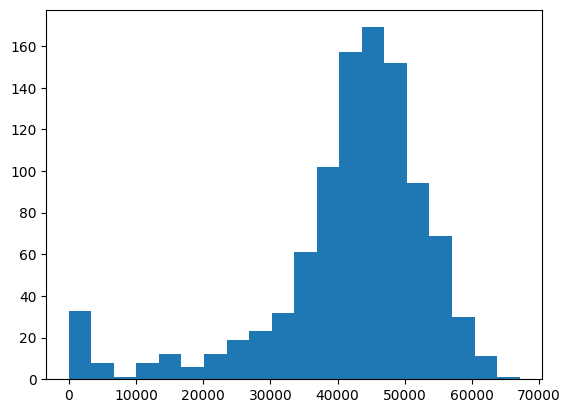

In [40]:
plt.hist(adc150, bins=rices_rule(adc150))

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.333e-10                  │              Nfcn = 134              │
│ EDM = 1.94e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha │     0     │  0.06e6   │            │            │         │         │       │
│ 1 │ n     │    0e6    │    5e6    │            │            │         │         │       │
│ 2 │ mu    │     0     │   0.4e9   │            │            │         │         │       │
│ 3 │ sigma │     0     │   0.6e9   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │     alpha         n        mu     sigma │
├───────┼─────────────────────────────────────────┤
│ alpha │  4.16e+09    -167e9      24e9 -6.606e12 │
│     n │    -167e9  2.75e+13 -0.626e15  2.603e15 │
│    mu │      24e9 -0.626e15  1.98e+17  -0.13e18 │
│ sigma │ -6.606e12  2.603e15  -0.13e18  3.96e+17 │
└───────┴─────────────────────────────────────────┘

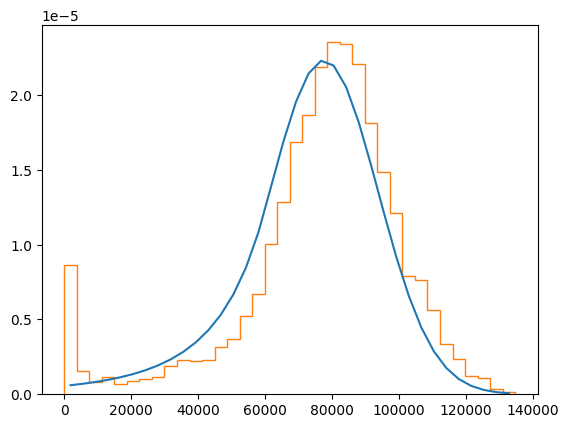

In [52]:
def fit_crystal_ball(arr):

    Nbins = rices_rule(arr)
#    Nbins = 30
    hist, bins = np.histogram(arr, bins=Nbins)
    bin_centers = bins[:-1] + np.diff(bins) / 2


    # Manual removal
#    bin_centers = bins[:-1] + np.diff(bins) / 2
#    mask = bin_centers < 12E3
#    hist[mask] = 0
    


    
#    hist = hist/hist.max()
    hist_norm = (np.sum(hist) * np.diff(bins)[0])
#    hist = hist / (hist_sum)
    hist = hist / hist_norm
    
    x_data = bin_centers
    y_data = hist

    y_data = y_data

    
    def least_squares(alpha, n, mu, sigma):
        predicted = crystal_ball(x_data, alpha, n, mu, sigma, False, True)
        return np.sum((y_data - predicted)**2)


    m = Minuit(least_squares, alpha=5, n=10, mu=arr.mean()+1E3, sigma=arr.std()/1.5)
    m.migrad()
    m.hesse()

    f_alpha = m.values['alpha']
    f_n = m.values['n']
    f_mu = m.values['mu']
    f_sigma = m.values['sigma']


    plt.plot(x_data, crystalball.pdf(x_data, beta=f_alpha, m=f_n, loc=f_mu, scale=f_sigma))
    
    plt.stairs(hist, bins)

    return m

fit_crystal_ball(adc350)

In [179]:
 5.8196e3 

5819.6

In [159]:
76.4064e3

76406.4

In [165]:
 5.8196e3 

5819.6

In [160]:
 762.4 

762.4

# Crystal Ball vs Gaussian

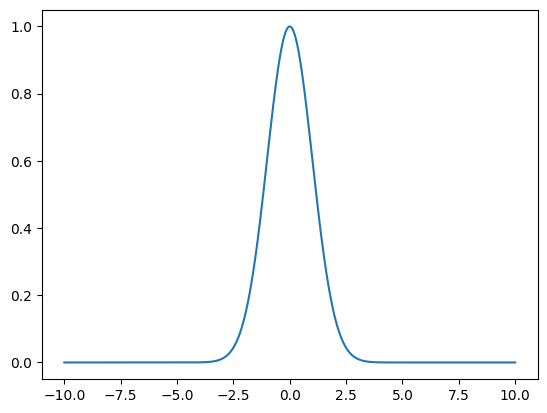

In [43]:
def plot_gaussian(A,mu,sigma):
    x = np.linspace(-10,10,1000)
    y = gaussian(x, A, mu, sigma)
    plt.plot(x,y)

plot_gaussian(1,0,1)

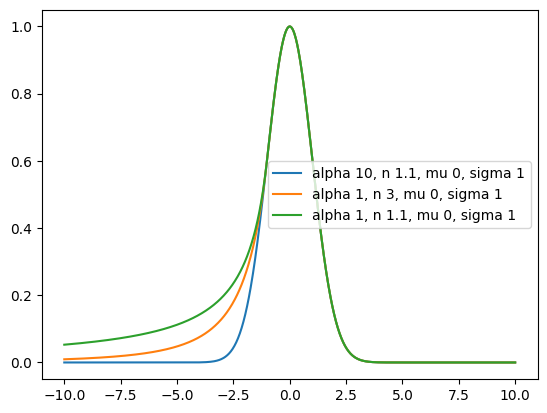

In [131]:


def plot_crystal_ball(alpha, n, mu, sigma, ax, label):
    x = np.linspace(-10,10,1000)
    y = crystal_ball(x, alpha, n, mu, sigma, False)
    ax.plot(x,y,label=label)


fig,ax = plt.subplots()
plot_crystal_ball(10, 1.1, 0, 1, ax, f"alpha {10}, n {1.1}, mu {0}, sigma {1}")
plot_crystal_ball(1, 3, 0, 1, ax, f"alpha {1}, n {3}, mu {0}, sigma {1}")
plot_crystal_ball(1, 1.1, 0, 1, ax, f"alpha {1}, n {1.1}, mu {0}, sigma {1}")

ax.legend()

#crystal_ball(np.array([1,2,3]), 1, 1, 1, 0, 1)

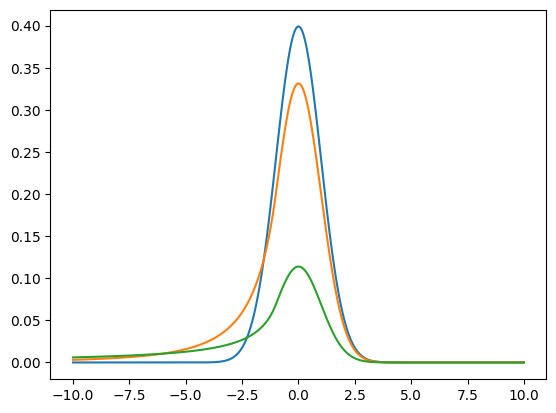

In [45]:
x = np.linspace(-10,10,1000)
y = crystalball.pdf(x, beta=10, m=1.1, loc=0, scale=1)
plt.plot(x,y)

y = crystalball.pdf(x, beta=1, m=3, loc=0, scale=1)
plt.plot(x,y)

y = crystalball.pdf(x, beta=1, m=1.1, loc=0, scale=1)
plt.plot(x,y)


#plot_crystal_ball(10, 1.1, 0, 1)
#plot_crystal_ball(1, 3, 0, 1)
#plot_crystal_ball(1, 1.1, 0, 1)




# New try

In [2]:
def adc(fname):
    tfile = ROOT.TFile(fname, "READ")
    ttree = tfile.Get("EventsTree")
    Nentries = ttree.GetEntries()
    adc = np.zeros(Nentries)
    for e in range(Nentries):
        ttree.GetEntry(e)
        vals = np.array(ttree.value, dtype=np.float32)
        adc[e] = vals.sum()
    return adc



In [31]:
en350 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/TRAIN_E350_N5600_GEN.root"
en300 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/TRAIN_E300_N10000_GEN.root"
en250 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/TRAIN_E250_N10000_GEN.root"
en200 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/TRAIN_E200_N10000_GEN.root"
en150 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/TRAIN_E150_N10000_GEN.root"
en100 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/TRAIN_E100_N10000_GEN.root"
en80 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/TRAIN_E80_N10000_GEN.root"
en60 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/TRAIN_E60_N10000_GEN.root"
en40 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/TRAIN_E40_N10000_GEN.root"
en20 = "/home/bjartur/workspace/focalh_data_transformer/data/converted/TRAIN_E20_N10000_GEN.root"




adc350 = adc(en350)
adc300 = adc(en300)
adc250 = adc(en250)
adc200 = adc(en200)
adc150 = adc(en150)
adc100 = adc(en100)
adc80 = adc(en80)
adc60 = adc(en60)
adc40 = adc(en40)
adc20 = adc(en20)






In [29]:
adc350

array([ 83408., 123550.,  92364., ...,  72266.,  82754.,  92196.])

In [25]:
bins = 100
hist, bin_edges = np.histogram(adc350, bins)

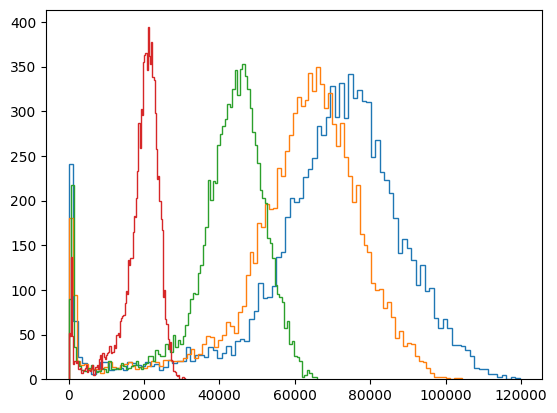

In [32]:
hist, bin_edges = np.histogram(adc300, bins)
plt.stairs(hist, bin_edges)
hist, bin_edges = np.histogram(adc250, bins)
plt.stairs(hist, bin_edges)
hist, bin_edges = np.histogram(adc150, bins)
plt.stairs(hist, bin_edges)
hist, bin_edges = np.histogram(adc60, bins)
plt.stairs(hist, bin_edges)



In [40]:
bin_edges.shape

(101,)

In [41]:
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_centers.shape

(100,)

mu_pre: 81826.05646355975, sigma_pre: 16021.518652112827
mu: 81894.56057543374, sigma: 15768.409395873252


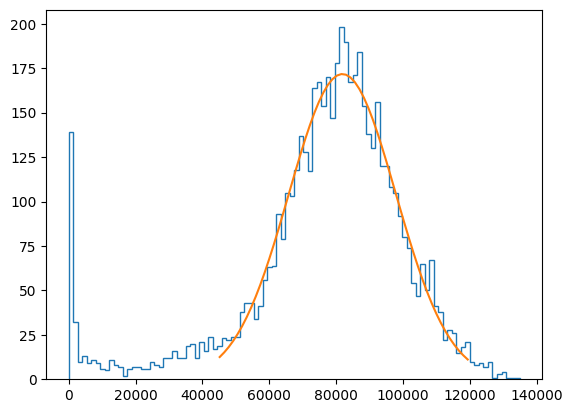

mu_pre: 73403.01823307476, sigma_pre: 13995.355198208637
mu: 73452.03470406015, sigma: 13823.433533011637


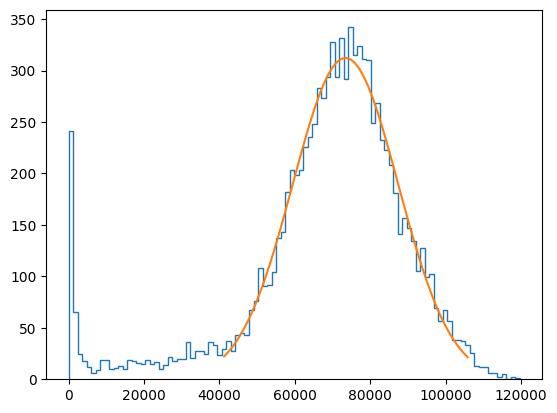

mu_pre: 64874.90974523741, sigma_pre: 11847.416583077102
mu: 64922.48461049793, sigma: 11716.027817095332


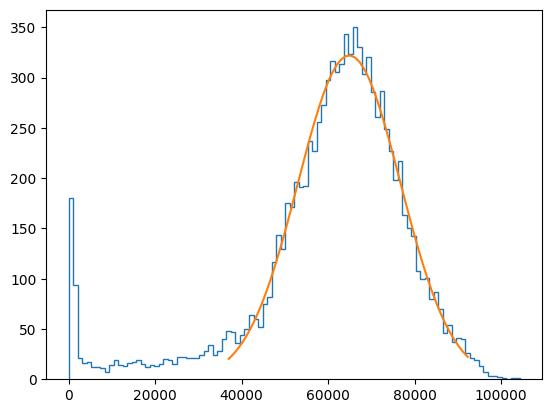

mu_pre: 55391.88100023529, sigma_pre: 9652.843983638184
mu: 55451.295210074684, sigma: 9537.041538374518


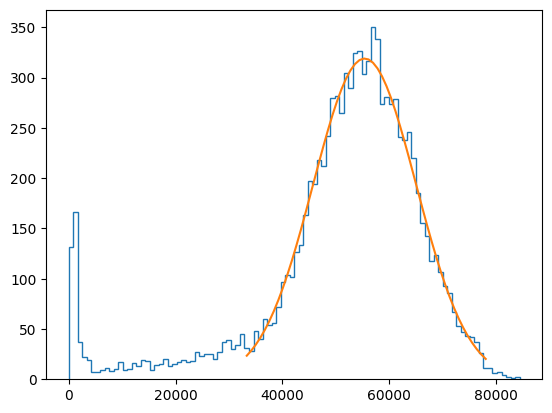

mu_pre: 44705.891812255184, sigma_pre: 7184.255868650374
mu: 44744.11983328922, sigma: 7120.552915908518


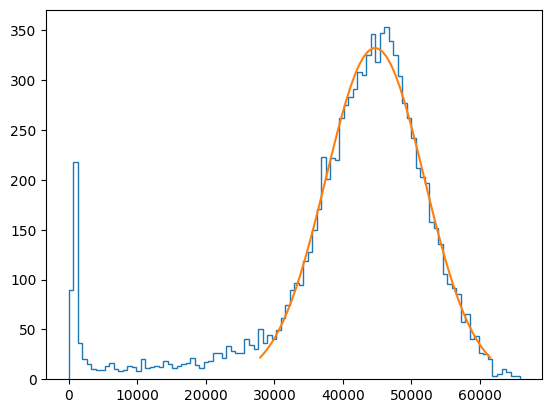

mu_pre: 32471.971178312757, sigma_pre: 4663.327631095932
mu: 32501.86381593953, sigma: -4610.59158313348


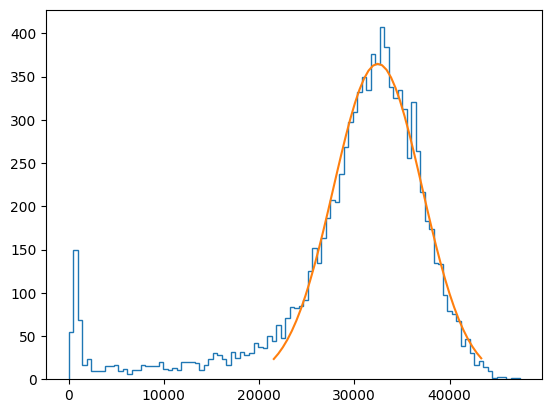

mu_pre: 26980.756466402796, sigma_pre: 3785.1146252217736
mu: 27015.912828285884, sigma: -3723.8907322996156


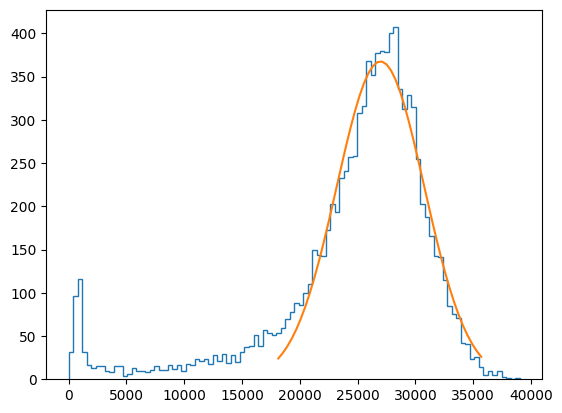

mu_pre: 20848.50064936257, sigma_pre: 3050.8597267666782
mu: 20875.189615482683, sigma: 3007.1705938591203


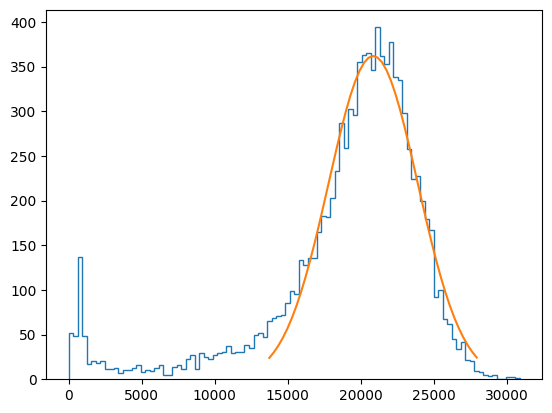

In [177]:
def gauss(x, A, mu, sigma):
    return A * np.exp(-(x-mu)**2 / (2*sigma**2))
    
def fit_peak(adcdata, bins):
    hist, bin_edges = np.histogram(adcdata, bins)
    plt.stairs(hist, bin_edges)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    p0 = [np.max(hist), np.mean(bin_centers), np.std(bin_centers)]
    par_prefit, _ = opt.curve_fit(gauss, bin_centers, hist, p0=p0)
    mu_est, sigma_est = par_prefit[1], par_prefit[2]
    fwhm = 2.355 * sigma_est
    mask = (bin_centers > mu_est - fwhm) & (bin_centers < mu_est + fwhm)
    print(f"mu_pre: {par_prefit[1]}, sigma_pre: {par_prefit[2]}")
    
    #plt.plot(bin_centers, cb_func(bin_centers, *par))
    plt.plot(bin_centers[mask], gauss(bin_centers, *par_prefit)[mask])

    par, cov = curve_fit(gauss, bin_centers[mask], hist[mask], p0=p0)
    print(f"mu: {par[1]}, sigma: {par[2]}")
    plt.show()
    return par, cov

def cb_func(x, alpha, n, mu, sigma, amplitude):
    return amplitude * crystalball.pdf(x, alpha, n, mu, sigma)


hist_fits = dict()

hist_fits["350"] = fit_peak(adc350, 100)
hist_fits["300"] = fit_peak(adc300, 100)
hist_fits["250"] = fit_peak(adc250, 100)
hist_fits["200"] = fit_peak(adc200, 100)
hist_fits["150"] = fit_peak(adc150, 100)
hist_fits["100"] = fit_peak(adc100, 100)
hist_fits["80"] = fit_peak(adc80, 100)
hist_fits["60"] = fit_peak(adc60, 100)
#hist_fits["40"] = fit_peak(adc40, 100)
#hist_fits["20"] = fit_peak(adc20, 100)

In [178]:
with open("hist_fits.pkl", "wb") as handle:
    pickle.dump(hist_fits, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [179]:

mask = (bin_centers > 40000) & (bin_centers < 100000)

bin_centers[mask]

array([40053.94, 41249.58, 42445.22, 43640.86, 44836.5 , 46032.14,
       47227.78, 48423.42, 49619.06, 50814.7 , 52010.34, 53205.98,
       54401.62, 55597.26, 56792.9 , 57988.54, 59184.18, 60379.82,
       61575.46, 62771.1 , 63966.74, 65162.38, 66358.02, 67553.66,
       68749.3 , 69944.94, 71140.58, 72336.22, 73531.86, 74727.5 ,
       75923.14, 77118.78, 78314.42, 79510.06, 80705.7 , 81901.34,
       83096.98, 84292.62, 85488.26, 86683.9 , 87879.54, 89075.18,
       90270.82, 91466.46, 92662.1 , 93857.74, 95053.38, 96249.02,
       97444.66, 98640.3 , 99835.94])

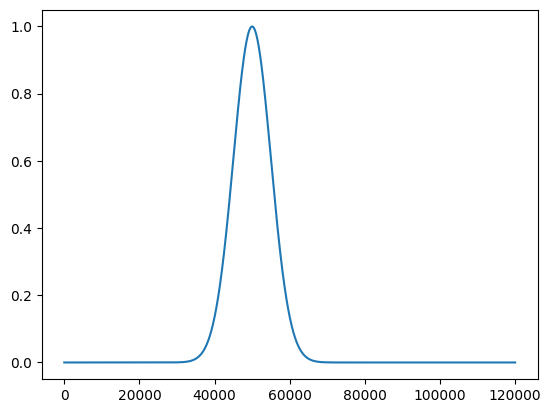

In [180]:
def gauss(x, A, mu, sigma):
    return A * np.exp(-(x-mu)**2 / (2*sigma**2))
    
x = np.linspace(0,120000,1000)
plt.plot(x, gauss(x, 1, 50000, 5000))

In [181]:
ens = []
mu_adc = []
sigma_adc = []
for k,p in hist_fits.items():
    ens.append(int(k))
    mu_adc.append(p[0][1])
    sigma_adc.append(abs(p[0][2]))
ens = np.array(ens)
mu_adc = np.array(mu_adc)
sigma_adc = np.array(sigma_adc)


[  209.2261091 11138.8198462]


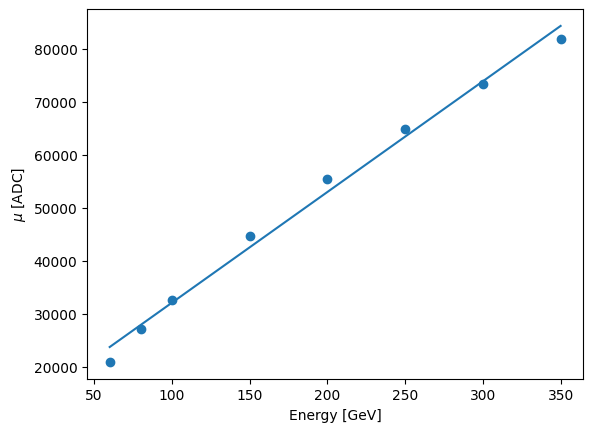

In [182]:
def lin(x,a,b):
    return a*x + b
p0=[600,0]

mask = ens > -20

par,cov = opt.curve_fit(lin, ens[mask], mu_adc[mask], p0=p0)
plt.scatter(ens, mu_adc)
plt.xlabel("Energy [GeV]")
plt.ylabel("$\\mu$ [ADC]")
plt.plot(ens, lin(ens, *par))
print(par)

In [183]:
mu_E = (mu_adc - par[1])/par[0]
sigma_E = sigma_adc / par[0]
sigma_E

array([75.36539997, 66.0693524 , 55.99696839, 45.58246377, 34.03281238,
       22.03640647, 17.7984036 , 14.37282664])

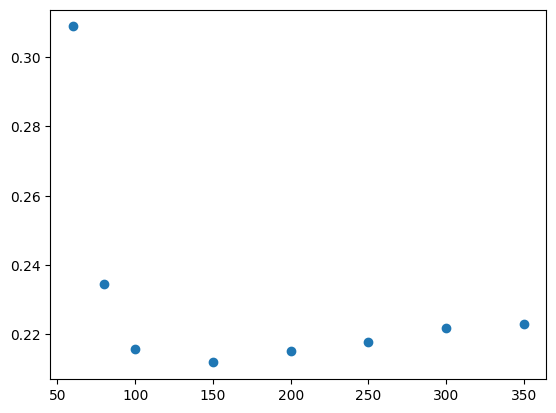

In [184]:
plt.scatter(ens, (sigma_E/mu_E))

In [167]:
for i in range(len(ens)):
    print(sigma_adc[i], mu_adc[i])

15768.409395873252 81894.56057543374
13823.433533011637 73452.03470406015
11716.027817095332 64922.48461049793
9537.041538374518 55451.295210074684
7120.552915908518 44744.11983328922
-4610.59158313348 32501.86381593953
-3723.8907322996156 27015.912828285884
3007.1705938591203 20875.189615482683
2450.2133646902466 14208.913228775657
1513.6357276898473 6915.285740412088
